<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/2021-03-14-tabular-data-variational-autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation for tabular data


+ https://colab.research.google.com/github/lschmiddey/fastpages_/blob/master/_notebooks/2021-03-14-tabular-data-variational-autoencoder.ipynb

## How to create fake tabular data with a variational autoencoder to improve deep learning algorithms

+ 참조 : https://process-mining.tistory.com/161

+ bucket 별로, mu & sigma를 산출하고, 별도의 예측 모델을 통해, bucket에 따른 mu & sigma를 추정할 수 있도록 한다.
+ mu,sigma = f(b)
+ 따라서, 향후의 bucket 를 입력하여 미래의 mu, sigma를 추정하도록 한다.
+ 추정된 mu, sigma를 통해, decoder에서 가상 data를 생성한다.

To train deeplearning models the more data the better. When we're thinking of image data, the deeplearnig community thought about a lot of tricks how to enhance the model given a dataset of images. Meaning that by rotating, flipping, blurring etc. the image we can create more input data and also improve our model. 

However, when thinking about tabular data, only few of these techniques exist. In this blogpost I want to show you how to create a variational autoencoder and make use of data augmentation. I will create fake data, which is sampled from the learned distribution of the underlying data. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataset Overview

In [4]:
data_size = 80000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [5]:
import seaborn as sns
sns.set()
seed_everything()     
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    #sns.scatterplot(x=x[:,ix],y=y)

In [6]:
seed_everything(5)

for i in range(int(data_size/100)):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)    
    x[s:s+100,4] = y[s:s+100] + np.random.normal(0,8*(i/100),100)
    #x[s:s+100,5] = i
#sns.scatterplot(x=x[0:200,4],y=y[0:200])
#sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

In [7]:

columns=['x0','x1','x2','x3','z0']
df_base = pd.DataFrame(x,columns=columns)

In [8]:
df_base

,x0,x1,x2,x3,z0
0,0.328816,0.595719,2.051881,1.092179,1.000000
1,2.356306,3.095096,1.664174,1.320007,1.000000
2,4.178988,1.609953,-0.869306,1.064534,1.000000
3,-0.536496,1.664963,2.669758,1.630250,0.000000
4,3.378180,1.613911,1.614898,1.883298,1.000000
...,...,...,...,...,...
79995,1.878721,-0.673022,-0.268455,0.260712,46.506583
79996,2.540145,0.507712,1.072800,1.739879,170.985104
79997,1.549017,0.830536,1.583444,0.730883,-40.320343
79998,-0.653163,2.199681,3.471523,2.516042,46.242861


In [9]:
# bucket 하나의 크기는 100
# 2000개의 학습데이터에는 20개의 bucket이 있음.
# 학습데이터 100개당 +1의 bucket count를 증가 시킴
#df_base['b'] = [int(b)/400 for b in df_base.index.values/100]

In [10]:
df_base['y'] = y

In [11]:
cols = df_base.columns

In [12]:
df_base

,x0,x1,x2,x3,z0,y
0,0.328816,0.595719,2.051881,1.092179,1.000000,1
1,2.356306,3.095096,1.664174,1.320007,1.000000,1
2,4.178988,1.609953,-0.869306,1.064534,1.000000,1
3,-0.536496,1.664963,2.669758,1.630250,0.000000,0
4,3.378180,1.613911,1.614898,1.883298,1.000000,1
...,...,...,...,...,...,...
79995,1.878721,-0.673022,-0.268455,0.260712,46.506583,0
79996,2.540145,0.507712,1.072800,1.739879,170.985104,1
79997,1.549017,0.830536,1.583444,0.730883,-40.320343,0
79998,-0.653163,2.199681,3.471523,2.516042,46.242861,1


## Build Data Loader

In [13]:
def load_and_standardize_data(data):
    # read in from csv
    df = data #pd.read_csv(path, sep=',')
    # replace nan with -99
    df = df.fillna(-99)
    X_train = df.values.reshape(-1, df.shape[1]).astype('float32')
    # randomly split
    #X_train = df #, X_test = train_test_split(df, test_size=0.0, random_state=42)
    # standardize values
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    #X_test = scaler.transform(X_test)   
    return X_train, scaler #, X_test #, scaler

In [14]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, df, train=True):
        self.X_train,self.standardizer  = load_and_standardize_data(df) #, self.standardizer = load_and_standardize_data(df)
        self.x = torch.from_numpy(self.X_train)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [15]:
traindata_set=DataBuilder(df_base[0:72000][['x0','x1','x2','x3','z0','y']], train=True)
testdata_set=DataBuilder(df_base[72000:80000][['x0','x1','x2','x3','z0','y']], train=True)

trainloader=DataLoader(dataset=traindata_set,batch_size=1024)
testloader=DataLoader(dataset=testdata_set,batch_size=1024)

In [16]:
type(trainloader.dataset.x), type(testloader.dataset.x)

(torch.Tensor, torch.Tensor)

In [17]:
trainloader.dataset.x.shape, testloader.dataset.x.shape

(torch.Size([72000, 6]), torch.Size([8000, 6]))

In [18]:
trainloader.dataset.x

tensor([[-0.7438, -0.6940,  0.5376, -0.4706,  0.0077,  0.9984],
        [ 0.5397,  1.2280,  0.1621, -0.2053,  0.0077,  0.9984],
        [ 1.6935,  0.0859, -2.2912, -0.5028,  0.0077,  0.9984],
        ...,
        [-0.8851, -0.7440,  0.7210, -0.9956,  0.7809, -1.0016],
        [ 0.2326,  0.9141,  0.3609,  2.0102, -2.5483,  0.9984],
        [ 0.4907,  1.1298,  0.9089, -0.4090, -1.0284, -1.0016]])

## Build model

In [19]:
class Autoencoder(nn.Module):
    def __init__(self,D_in,H=50,H2=12,latent_dim=3):
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        
        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        
        # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))


        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [20]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

If you want to better understand the variational autoencoder technique, look [here](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73).

For better understanding this AutoencoderClass, let me go briefly through it. This is a variational autoencoder (VAE) with two hidden layers, which (by default, but you can change this) 50 and then 12 activations. The latent factors are set to 3 (you can change that, too). So we're first exploding our initially 14 variables to 50 activations, then condensing it to 12, then to 3. From these 3 latent factors we then sample to recreate the original 14 values. We do that by inflating the 3 latent factors back to 12, then 50 and finally 14 activations (we decode the latent factors so to speak). With this reconstructed batch (recon_batch) we compare it with the original batch, computate our loss and adjust the weights and biases via our gradient (our optimizer here will be Adam). 

## Train Model

In [21]:
seed_everything()

D_in = trainloader.dataset.x.shape[1]
H = D_in*10
H2 = int(H/2)
latent_dim = 3
gen_model = Autoencoder(D_in, H, H2,latent_dim).to(device)
optimizer = optim.Adam(gen_model.parameters(), lr=1e-3)
loss_mse = customLoss()

In [22]:
epochs = 2000
log_interval = 50
val_losses = []
train_losses = []
test_losses = []

In [23]:
def train(epoch):
    gen_model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        #b = torch.tensor(int(batch_idx/100)/400,dtype=torch.float32).to(device)
        recon_batch, mu, logvar = gen_model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % 200 == 0:        
        print('====> Epoch: {} Average training loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

In [24]:
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            #b = torch.tensor((int(batch_idx+1800)/100)/400,dtype=torch.float32).to(device)
            recon_batch, mu, logvar = gen_model(data)
            loss = loss_mse(recon_batch, data, mu, logvar)
            test_loss += loss.item()
            if epoch % 200 == 0:        
                print('====> Epoch: {} Average test loss: {:.4f}'.format(
                    epoch, test_loss / len(testloader.dataset)))
            test_losses.append(test_loss / len(testloader.dataset))

In [25]:
seed_everything()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

====> Epoch: 200 Average training loss: 4.7277
====> Epoch: 200 Average test loss: 0.6027
====> Epoch: 200 Average test loss: 1.1995
====> Epoch: 200 Average test loss: 1.7992
====> Epoch: 200 Average test loss: 2.3962
====> Epoch: 200 Average test loss: 3.0093
====> Epoch: 200 Average test loss: 3.6041
====> Epoch: 200 Average test loss: 4.2153
====> Epoch: 200 Average test loss: 4.7157
====> Epoch: 400 Average training loss: 4.7194
====> Epoch: 400 Average test loss: 0.5938
====> Epoch: 400 Average test loss: 1.1906
====> Epoch: 400 Average test loss: 1.7926
====> Epoch: 400 Average test loss: 2.3915
====> Epoch: 400 Average test loss: 2.9988
====> Epoch: 400 Average test loss: 3.5935
====> Epoch: 400 Average test loss: 4.2017
====> Epoch: 400 Average test loss: 4.6953


KeyboardInterrupt: ignored

In [26]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = gen_model(data)

In [27]:
scaler = trainloader.dataset.standardizer
recon_row = scaler.inverse_transform(recon_batch.cpu().data.numpy())

In [28]:
recon_row = pd.DataFrame(recon_row, columns = ['x0','x1','x2','x3','z0','y'])
recon_row

,x0,x1,x2,x3,z0,y
0,2.666905,1.280690,2.255773,2.066692,20.979309,0.964730
1,2.074806,-0.259067,0.961438,0.908439,10.382992,-0.002712
2,0.342568,0.452859,0.914502,0.912078,9.860591,-0.009438
3,1.054401,-0.727509,1.257784,1.127402,-33.891888,-0.011018
4,1.538805,2.037016,1.280005,1.456181,-17.451170,0.488697
...,...,...,...,...,...,...
827,1.407142,0.467593,0.898060,0.885277,13.779286,-0.001141
828,1.135353,0.552976,2.084719,2.050271,20.486582,0.970427
829,-0.085729,1.229808,0.841451,0.879668,14.288430,-0.003292
830,0.383338,2.761308,2.255316,2.071189,2.915334,0.965915


In [29]:
sigma = torch.exp(logvar/2)

In [30]:
# sample z from q
no_samples = 20
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))

In [31]:
with torch.no_grad():
    fake_data = gen_model.decode(z).cpu().numpy()

In [32]:
fake_data = scaler.inverse_transform(fake_data)

In [33]:
df_fake = pd.DataFrame(fake_data, columns = ['x0','x1','x2','x3','z0','y'])
df_fake

,x0,x1,x2,x3,z0,y
0,2.141290,0.202230,0.912266,0.875451,14.647469,0.002907
1,0.789609,0.967136,0.853816,0.880534,15.338101,0.011130
2,1.443186,1.928890,1.147629,1.260710,-13.785330,0.264294
3,0.147169,1.937786,0.896657,0.932424,8.692473,0.036600
4,1.433300,1.743626,0.934258,0.994244,-3.473374,0.053648
5,1.548840,2.396596,2.222054,2.102086,2.731363,1.008405
6,2.782551,2.023446,1.668022,1.888281,-17.015745,0.942302
7,1.930371,2.108174,2.369017,2.131773,14.199686,1.006679
8,2.973575,2.147310,1.837097,1.970464,-12.048023,0.972372
9,-0.019602,2.371894,1.037512,1.075595,-0.973015,0.101310


## mu, sigma 추이 보기...

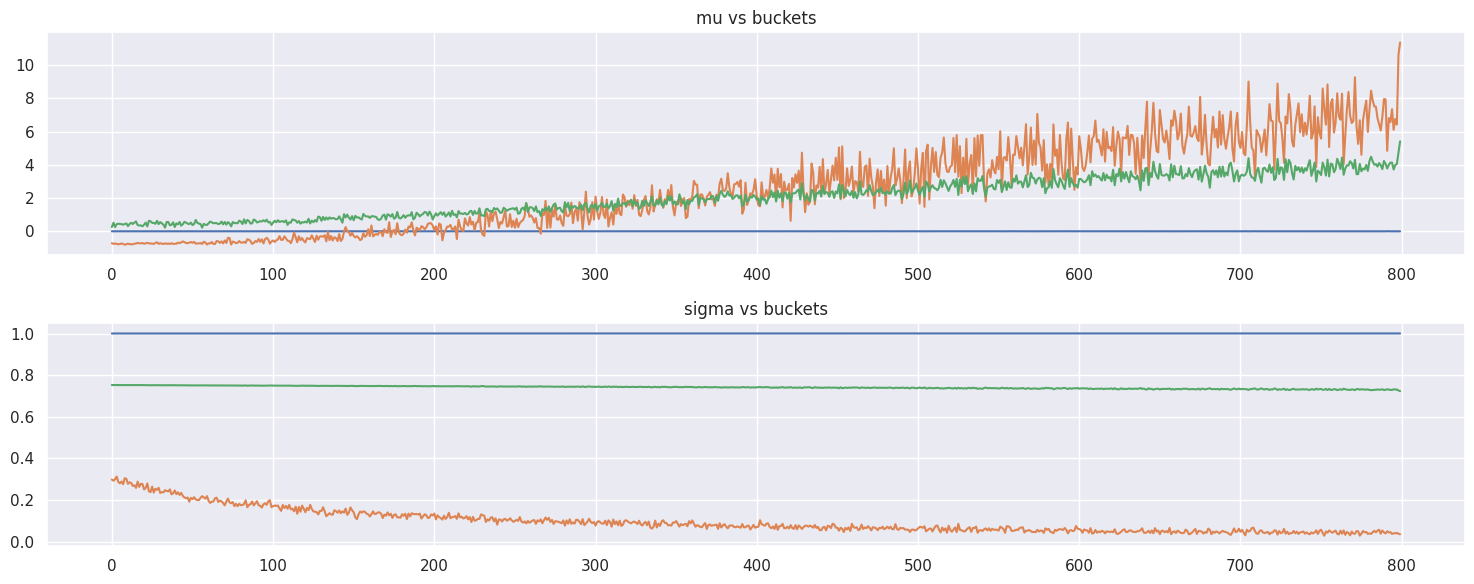

In [34]:
import matplotlib.pyplot as plt

mus = []
sigs = []
X_train = torch.tensor(df_base[['x0','x1','x2','x3','z0','y']].values, dtype=torch.float32).to(device)

gen_model.eval()
bucket_size = 100
bucket_count = int(X_train.shape[0]/bucket_size)

for batch_idx in range(bucket_count):
    data = X_train[batch_idx*bucket_size:batch_idx*bucket_size+bucket_size]
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, logvar = gen_model(data)
    sigma = torch.exp(logvar/2)
    mus.append(mu.mean(axis=0).cpu().data.numpy())
    sigs.append(sigma.mean(axis=0).cpu().data.numpy())
    #print(batch_idx,mus[-1])
mus = np.asarray(mus)
sigs = np.asarray(sigs)

plt.figure(figsize=(15,6))
plt.subplot(211)
plt.plot(mus)
plt.title('mu vs buckets')
plt.subplot(212)
plt.plot(sigs)
plt.title('sigma vs buckets')
plt.tight_layout()
plt.show()

In [35]:
mus.shape

(800, 3)

+ Trainset의 mu,sigma 추이

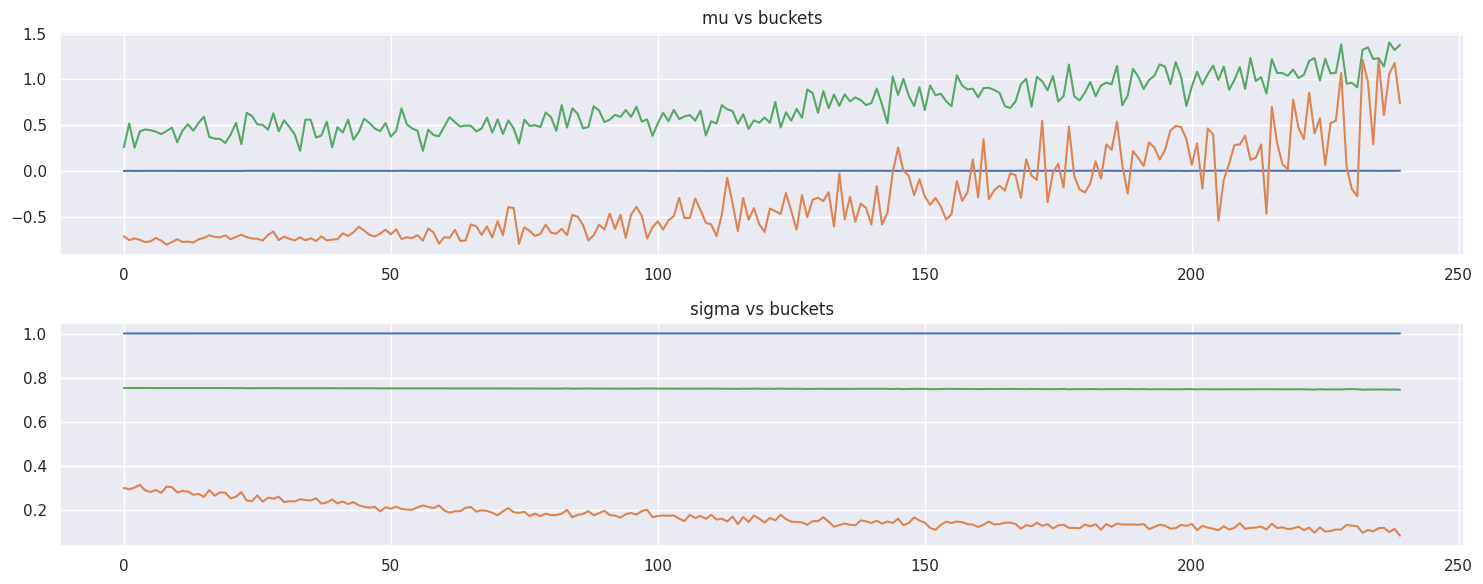

In [36]:
mus = []
sigs = []
X_train = torch.tensor(df_base[0:24000][['x0','x1','x2','x3','z0','y']].values, dtype=torch.float32).to(device)

bucket_size = 100
bucket_count = int(X_train.shape[0]/bucket_size)

for batch_idx in range(bucket_count):
    data = X_train[batch_idx*bucket_size:batch_idx*bucket_size+bucket_size]
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, logvar = gen_model(data)
    sigma = torch.exp(logvar/2)
    mus.append(mu.mean(axis=0).cpu().data.numpy())
    sigs.append(sigma.mean(axis=0).cpu().data.numpy())
    #print(batch_idx,mus[-1])
mus = np.asarray(mus)
sigs = np.asarray(sigs)

plt.figure(figsize=(15,6))
plt.subplot(211)
plt.plot(mus)
plt.title('mu vs buckets')
plt.subplot(212)
plt.plot(sigs)
plt.title('sigma vs buckets')
plt.tight_layout()
plt.show()



+ Trainset의 mu,sigma 추이
+ bucket count가 160개로 매우 적다. 이를 극복하기 위해서, 하나의 bucket에 대해 80%를 random 복원 sampling 하여 bucket count의 증가 효과를...
+ 할 수 있으나, 여기서는 하지 않음!

In [37]:
if False:
    mus = []
    sigs = []
    #X_train = torch.tensor(df_base[0:8000][['x0','x1','x2','x3','z0','y']].values, dtype=torch.float32).to(device)
    bucket_size = 100
    bucket_count = int(X_train.shape[0]/bucket_size)
    gen_model.eval()
    samling_count_per_bucket = 10
    for batch_idx in range(bucket_count):
        data = X_train[batch_idx*bucket_size:batch_idx*bucket_size+bucket_size]
        data = data.to(device)
        optimizer.zero_grad()
        for i in range(samling_count_per_bucket):
            s = np.random.choice(data.shape[0],int(data.shape[0]*0.8))
            recon_batch, mu, logvar = gen_model(data[s])
            sigma = torch.exp(logvar/2)
            mus.append(mu.mean(axis=0).cpu().data.numpy())
            sigs.append(sigma.mean(axis=0).cpu().data.numpy())
        #print(batch_idx,mus[-1])
    mus = np.asarray(mus)
    sigs = np.asarray(sigs)

    plt.figure(figsize=(15,6))
    plt.subplot(211)
    plt.plot(mus)
    plt.title('mu vs buckets')
    plt.subplot(212)
    plt.plot(sigs)
    plt.title('sigma vs buckets')
    plt.tight_layout()
    plt.show()
else:
    print("Pass")

Pass


## LSTM으로 학습

+ 시계열 성분을 위한 LSTM과 증감 성분을 고려하여 Regressor를 결합한 모델 사용.

### mu의 LSTM 학습

In [38]:
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length,:]
        x.append((_x))
        y.append(_y)

    return np.array(x),np.array(y)

mu_sc = StandardScaler()
mu_training_data = mu_sc.fit_transform(mus)

seq_length = 30

mu_x, mu_y = sliding_windows(mu_training_data, seq_length)

mu_train_size = int(len(mu_y) * 0.80)
mu_test_size = len(mu_y) - mu_train_size

mu_dataX = Variable(torch.Tensor(np.array(mu_x))).to(device)
mu_dataY = Variable(torch.Tensor(np.array(mu_y))).to(device)

mu_trainX = Variable(torch.Tensor(np.array(mu_x[0:mu_train_size]))).to(device)
mu_trainY = Variable(torch.Tensor(np.array(mu_y[0:mu_train_size]))).to(device)

mu_testX = Variable(torch.Tensor(np.array(x[mu_train_size:len(mu_x)]))).to(device)
mu_testY = Variable(torch.Tensor(np.array(y[mu_train_size:len(mu_y)]))).to(device)

In [39]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

        self.reg_model = nn.Sequential(
            nn.Linear(1, 50),
            nn.BatchNorm1d(num_features=50),
            nn.ReLU(),
            nn.Linear(50, num_classes) 
        )

    def forward(self, x,b):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out).reshape(num_layers,-1,num_classes)[-1]
        out2 = self.reg_model(b)

        return out*0.2 + out2

In [40]:
seed_everything()   

num_epochs = 2000
learning_rate = 0.001

input_size = latent_dim
hidden_size = latent_dim * 100
num_layers = 3

num_classes = latent_dim

mu_lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(mu_lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

b0 = torch.tensor(range(len(mu_trainX)), dtype=torch.float32).reshape(-1,1).to(device) * 0.0001

# Train the model
for epoch in range(num_epochs):

    outputs = mu_lstm(mu_trainX,b0)
    optimizer.zero_grad()
    
    # obtain the loss function
    #outputs = outputs.reshape(num_layers,-1,num_classes)[-1]

    loss = criterion(outputs, mu_trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.77653
Epoch: 100, loss: 0.31338
Epoch: 200, loss: 0.28842
Epoch: 300, loss: 0.28679
Epoch: 400, loss: 0.22609
Epoch: 500, loss: 0.17937
Epoch: 600, loss: 0.08069
Epoch: 700, loss: 0.02544
Epoch: 800, loss: 0.00378
Epoch: 900, loss: 0.00062
Epoch: 1000, loss: 0.00023
Epoch: 1100, loss: 0.00002
Epoch: 1200, loss: 0.00001
Epoch: 1300, loss: 0.00001
Epoch: 1400, loss: 0.00001
Epoch: 1500, loss: 0.00008
Epoch: 1600, loss: 0.00137
Epoch: 1700, loss: 0.00005
Epoch: 1800, loss: 0.00001
Epoch: 1900, loss: 0.00001


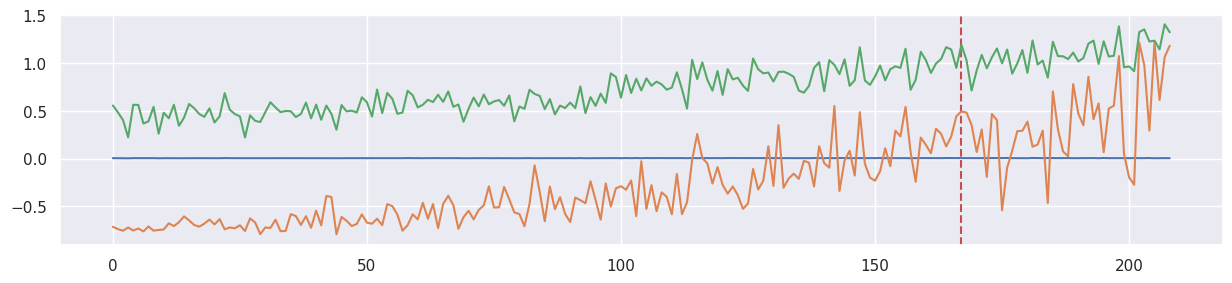

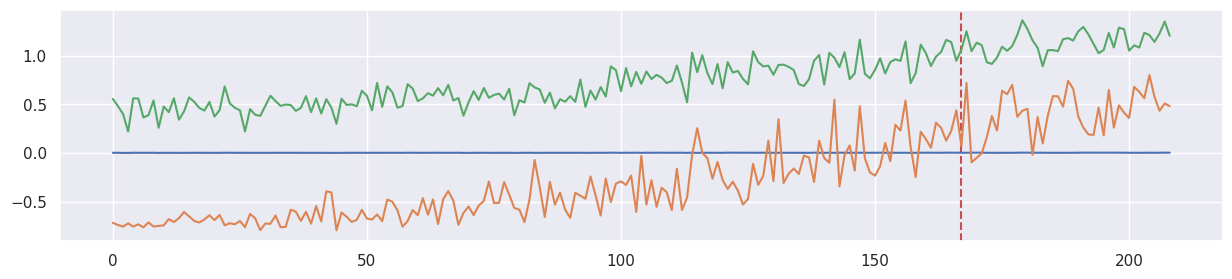

In [41]:
mu_lstm.eval()
b1 = torch.tensor(range(len(mu_dataX)), dtype=torch.float32).reshape(-1,1).to(device) * 0.0001
train_predict = mu_lstm(mu_dataX,b1)
data_predict = train_predict.cpu().data.numpy()
dataY_plot = mu_dataY.cpu().data.numpy()

data_predict = mu_sc.inverse_transform(data_predict)
dataY_plot = mu_sc.inverse_transform(dataY_plot)

plt.figure(figsize=(15,3))
plt.axvline(x=mu_train_size, c='r', linestyle='--')
plt.plot(dataY_plot)
plt.show()
plt.figure(figsize=(15,3))
plt.axvline(x=mu_train_size, c='r', linestyle='--')
plt.plot(data_predict)
plt.show()

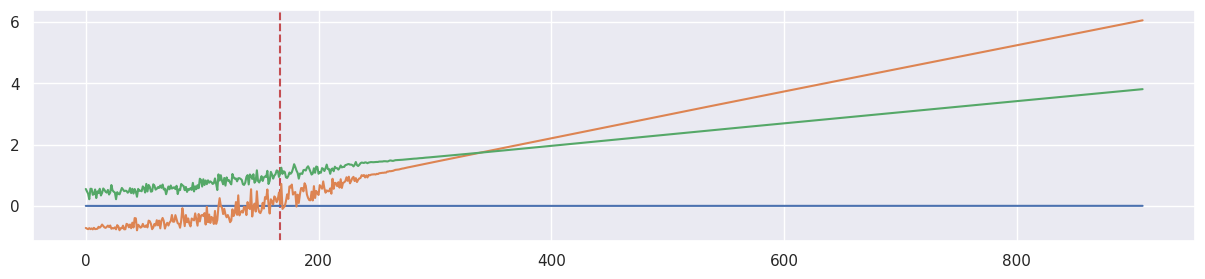

In [42]:
mu_lstm.eval()
train_predict = mu_lstm(mu_dataX,b1)

data_predict = train_predict.cpu().data.numpy()
dataY_plot = mu_dataY.cpu().data.numpy()

data_predict = mu_sc.inverse_transform(data_predict)
dataY_plot = mu_sc.inverse_transform(dataY_plot)

future_y = []
mu_last_x = mu_dataX[-1]
for pp in range(700):
    b2 = b1[-1] + torch.tensor(pp, dtype=torch.float32).reshape(-1,1).to(device) * 0.0001
    next_y = mu_lstm(mu_last_x.reshape((1,seq_length,latent_dim)),b2)

    mu_last_x = torch.concatenate((mu_last_x[1:seq_length],next_y),axis=0)
    future_y.append(mu_sc.inverse_transform(next_y.cpu().data.numpy())[0])

future_y = np.asarray(future_y)

data_predict = np.concatenate((data_predict,future_y),axis=0)

plt.figure(figsize=(15,3))
plt.axvline(x=mu_train_size, c='r', linestyle='--')
#plt.plot(dataY_plot)
plt.plot(data_predict)

plt.show()

### sigma의 LSTM 학습

In [43]:

sig_sc = StandardScaler()
sig_training_data = sig_sc.fit_transform(sigs)

sig_x, sig_y = sliding_windows(sig_training_data, seq_length)

sig_train_size = int(len(sig_y) * 0.80)
sig_test_size = len(sig_y) - sig_train_size

sig_dataX = Variable(torch.Tensor(np.array(sig_x))).to(device)
sig_dataY = Variable(torch.Tensor(np.array(sig_y))).to(device)

sig_trainX = Variable(torch.Tensor(np.array(sig_x[0:sig_train_size]))).to(device)
sig_trainY = Variable(torch.Tensor(np.array(sig_y[0:sig_train_size]))).to(device)

sig_testX = Variable(torch.Tensor(np.array(sig_x[sig_train_size:len(x)]))).to(device)
sig_testY = Variable(torch.Tensor(np.array(sig_y[sig_train_size:len(y)]))).to(device)

In [44]:
seed_everything()
'''
num_epochs = 2000
learning_rate = 0.001

input_size = latent_dim
hidden_size = latent_dim * 100
num_layers = 3

num_classes = latent_dim
'''
sig_lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(sig_lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

b0 = torch.tensor(range(len(sig_trainX)), dtype=torch.float32).reshape(-1,1).to(device) * 0.0001

# Train the model
for epoch in range(num_epochs):

    outputs = sig_lstm(sig_trainX,b0)
    optimizer.zero_grad()
    
    # obtain the loss function
    #outputs = outputs.reshape(num_layers,-1,num_classes)[-1]

    loss = criterion(outputs, sig_trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.56569
Epoch: 100, loss: 0.05800
Epoch: 200, loss: 0.05812
Epoch: 300, loss: 0.05430
Epoch: 400, loss: 0.05397
Epoch: 500, loss: 0.04207
Epoch: 600, loss: 0.03312
Epoch: 700, loss: 0.02592
Epoch: 800, loss: 0.01038
Epoch: 900, loss: 0.01468
Epoch: 1000, loss: 0.00532
Epoch: 1100, loss: 0.00196
Epoch: 1200, loss: 0.00095
Epoch: 1300, loss: 0.00087
Epoch: 1400, loss: 0.00023
Epoch: 1500, loss: 0.00054
Epoch: 1600, loss: 0.00003
Epoch: 1700, loss: 0.00001
Epoch: 1800, loss: 0.00000
Epoch: 1900, loss: 0.00000


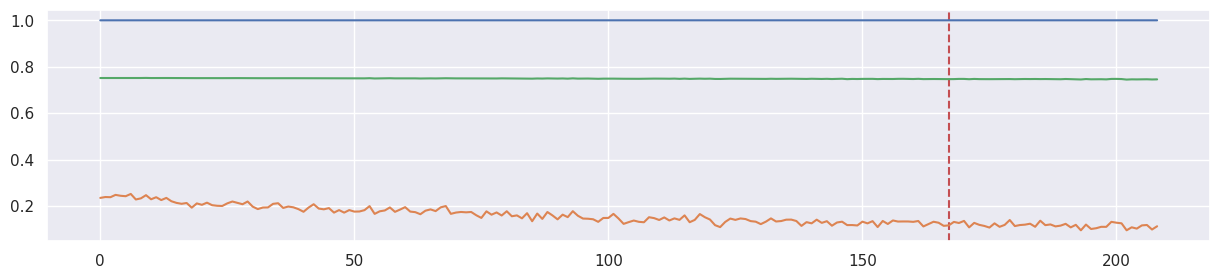

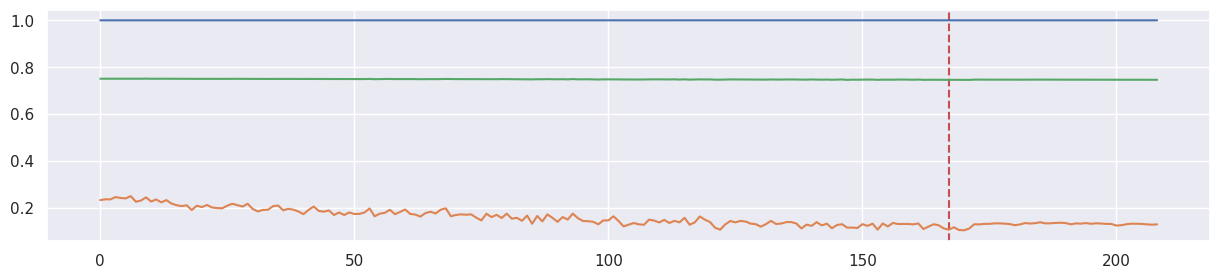

In [45]:
sig_lstm.eval()
b1 = torch.tensor(range(len(sig_dataX)), dtype=torch.float32).reshape(-1,1).to(device) * 0.0001
train_predict = sig_lstm(sig_dataX,b1)
data_predict = train_predict.cpu().data.numpy()
dataY_plot = sig_dataY.cpu().data.numpy()

data_predict = sig_sc.inverse_transform(data_predict)
dataY_plot = sig_sc.inverse_transform(dataY_plot)

plt.figure(figsize=(15,3))
plt.axvline(x=sig_train_size, c='r', linestyle='--')
plt.plot(dataY_plot)
plt.show()
plt.figure(figsize=(15,3))
plt.axvline(x=sig_train_size, c='r', linestyle='--')
plt.plot(data_predict)
plt.show()

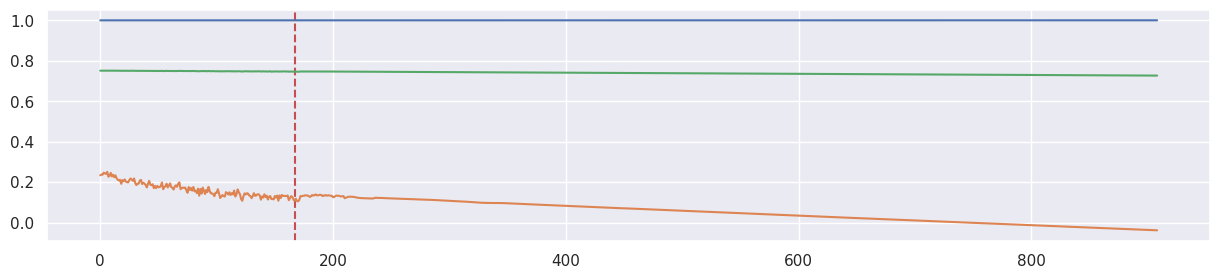

In [46]:
sig_lstm.eval()
train_predict = sig_lstm(sig_dataX,b1)

data_predict = train_predict.cpu().data.numpy()
dataY_plot = sig_dataY.cpu().data.numpy()

data_predict = sig_sc.inverse_transform(data_predict)
dataY_plot = sig_sc.inverse_transform(dataY_plot)

future_y = []
sig_last_x =sig_dataX[-1]
for pp in range(700):
    b2 = b1[-1] + torch.tensor(pp, dtype=torch.float32).reshape(-1,1).to(device) * 0.0001
    next_y = sig_lstm(sig_last_x.reshape((1,seq_length,latent_dim)),b2)

    sig_last_x = torch.concatenate((sig_last_x[1:seq_length],next_y),axis=0)
    future_y.append(sig_sc.inverse_transform(next_y.cpu().data.numpy())[0])

future_y = np.asarray(future_y)

data_predict = np.concatenate((data_predict,future_y),axis=0)

plt.figure(figsize=(15,3))
plt.axvline(x=sig_train_size, c='r', linestyle='--')
#plt.plot(dataY_plot)
plt.plot(data_predict)

plt.show()

# 학습 및 전체 적용

In [47]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

In [48]:
X = df_base

cuda:0
torch.Size([7200, 5])
torch.Size([7200, 1])


100%|██████████| 300/300 [00:31<00:00,  9.54it/s]


MSE: 0.35
RMSE: 0.60


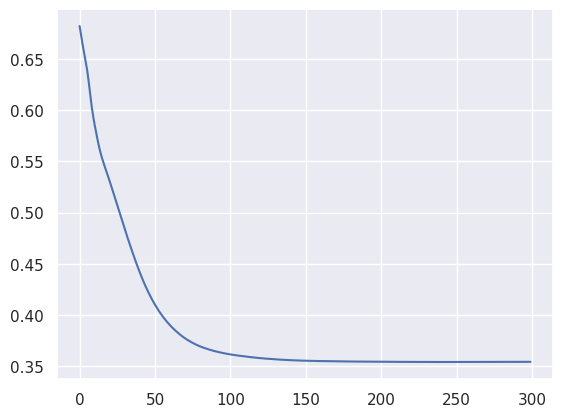

In [49]:
import copy
import torch.optim as optim
from tqdm import tqdm

seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:7200][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(X[0:7200]['y'].values, dtype=torch.float32).reshape(-1, 1).to(device)

print(X_train.shape)
print(y_train.shape)

X_test = torch.tensor(X[7200:8000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(X[7200:8000]['y'].values, dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
classifier_model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(classifier_model.parameters(), lr=0.0001)
 
n_epochs = 300   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    classifier_model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = classifier_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    classifier_model.eval()
    y_pred = classifier_model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(classifier_model.state_dict())
 
# restore model and return best accuracy
classifier_model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [50]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = classifier_model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

feature 5, test_f1 0.8337595907928389


## Ref_model 학습

cuda:0


100%|██████████| 10/10 [00:00<00:00, 31.47it/s]


MSE: 0.65
RMSE: 0.81


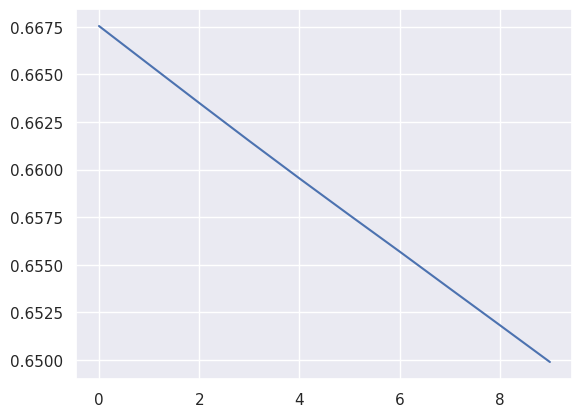

In [51]:
import copy
import torch.optim as optim
from tqdm import tqdm

seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
ref_model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    #nn.Dropout(0.2),
    nn.Linear(20, 5),
    nn.ReLU(),
    #nn.Dropout(0.2),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(ref_model.parameters(), lr=0.0001)
 
n_epochs = 10   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    ref_model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = ref_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    ref_model.eval()
    y_pred = ref_model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(ref_model.state_dict())
 
# restore model and return best accuracy
ref_model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [52]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = ref_model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

feature 5, test_f1 0.7647058823529412


# ks_test

In [53]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]   
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)
    
    #if ks_stat == minS:
    #    ks_stat = -ks_stat
    
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [54]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [55]:
columns=['x0','x1','x2','x3','z0']
mi_scores = make_mi_scores(X[columns], X['y'].values, discrete_features="auto")
print(mi_scores)

x3    0.201906
x2    0.135564
x1    0.080102
x0    0.055611
z0    0.005035
Name: MI Scores, dtype: float64


100%|██████████| 719/719 [00:05<00:00, 131.05it/s]


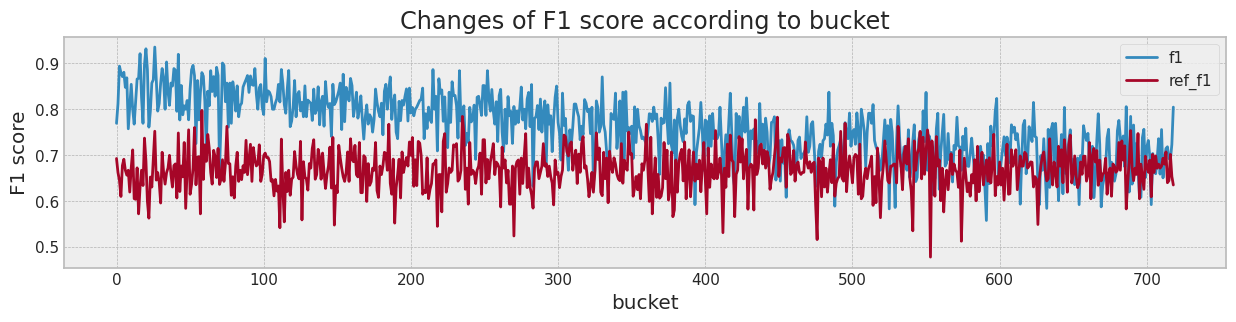

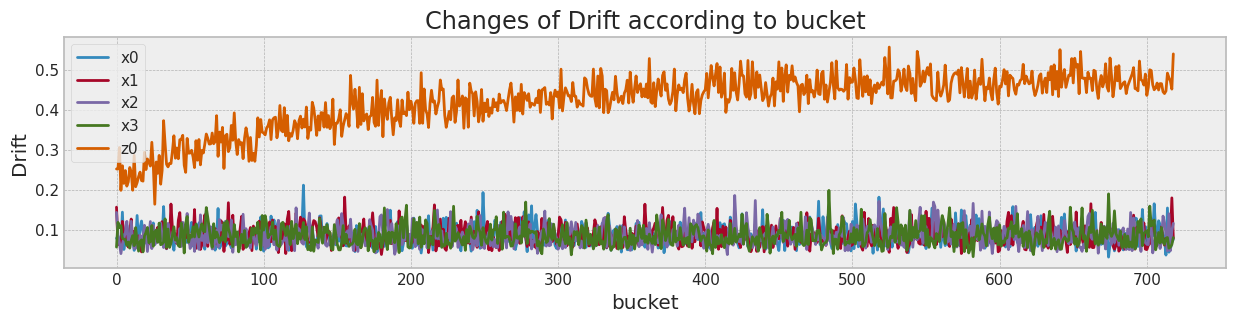

,lambda,test_f1,init_f1,mean_f1,last_f1,"MI(y^,z)"
0,Case #1 Feature 5,0.764706,0.769231,0.762164,0.804598,0.005035


In [56]:
result_table3 = {}
result_table3['lambda']=[]
result_table3['test_f1']=[]
result_table3['init_f1']=[]
result_table3['mean_f1']=[]
result_table3['last_f1']=[]
result_table3['MI(y^,z)']=[]

XT = X[8000:][['x0','x1','x2','x3','z0']]
yT = X[8000:]['y'].values

bucket_size_array=[100]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = {}
    f1s['f1'] = []
    f1s['ref_f1'] = []
    
    dfs = {}
    for col in columns:
        dfs[col] = []    

    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = classifier_model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        
        ref_y = ref_model(tmp_x)
        ref_y = (ref_y.cpu().data.numpy()> 0.5).astype(float)
        
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        rf1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],ref_y)

        #if bk == 1:
        #    tmp_gap = f1_ - rf1

        f1s['f1'].append(f1_)
        f1s['ref_f1'].append(rf1)        
        ks = __ks_drift(X[0:7200].values,X[bk*bucket_size+7200:bk*bucket_size+bucket_size+7200].values)
        for ix,col in enumerate(columns):
            dfs[col].append(ks[:,0][ix]) 

    df_f1s = pd.DataFrame(f1s)
    df_f1s.plot(figsize=(15,3))
    plt.ylabel('F1 score')
    plt.xlabel('bucket')
    plt.title('Changes of F1 score according to bucket')
    plt.show()

    df_drifts = pd.DataFrame(dfs)
    df_drifts.plot(figsize=(15,3))
    plt.ylabel('Drift')
    plt.xlabel('bucket')
    plt.title('Changes of Drift according to bucket')
    plt.show()

result_table3['lambda'].append('Case #1 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s['f1'][0])
result_table3['mean_f1'].append(np.mean(f1s['f1']))
result_table3['last_f1'].append(f1s['f1'][-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

# VAE에 의한 fake data의 적용

100%|██████████| 1000/1000 [00:15<00:00, 63.45it/s]


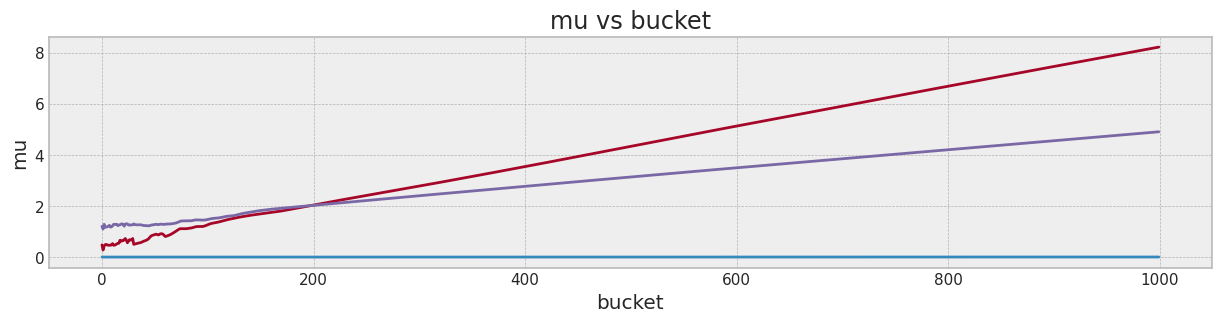

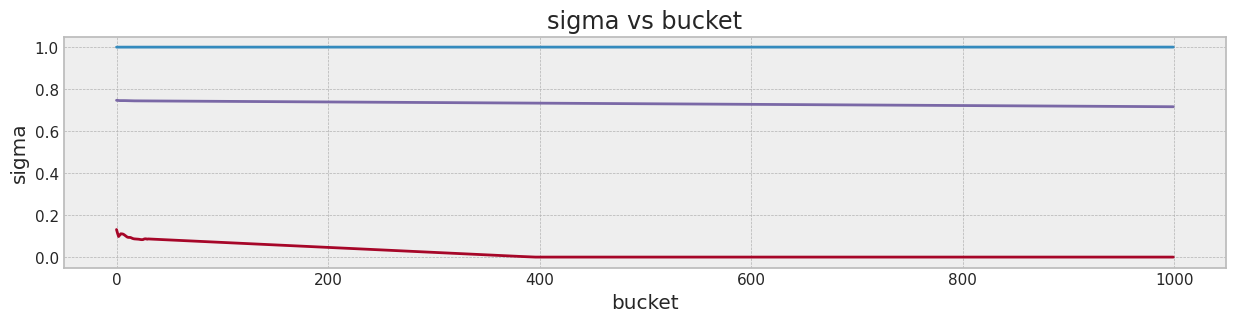

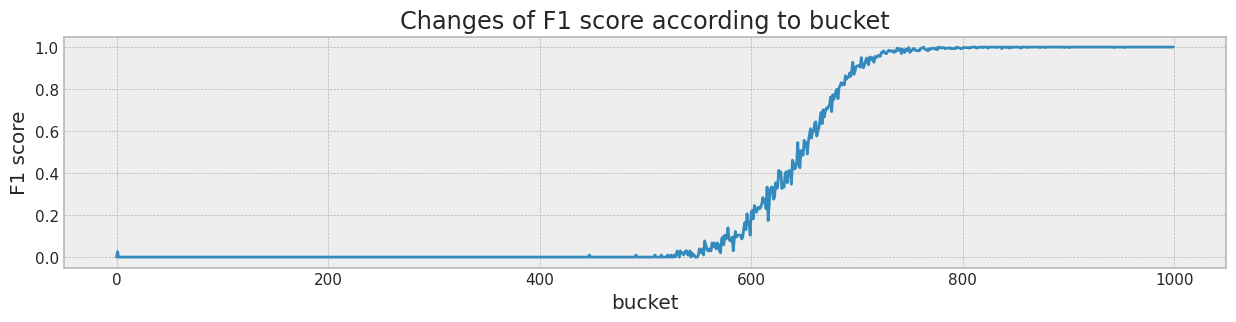

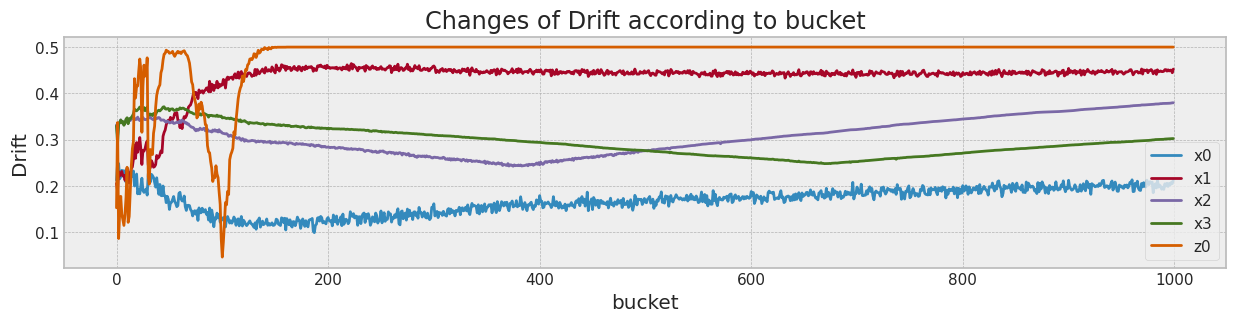

In [66]:
seed_everything()

mu_lstm.eval()
sig_lstm.eval()

mu_last_x =mu_dataX[-1]
sig_last_x =sig_dataX[-1]

no_samples = 200
simulation_count = 1000

ref_x = X[0:7200][['x0','x1','x2','x3','z0']].values
f1ss = []
dfs = {}
for col in columns:
    dfs[col] = []   
musig = {}
musig['mu'] = []
musig['sig'] = []


for pp in tqdm(range(simulation_count)):
    
    b2 = b1[-1] + torch.tensor(pp, dtype=torch.float32).reshape(-1,1).to(device) * 0.0001

    sim_mu = mu_lstm(mu_last_x.reshape((1,seq_length,latent_dim)),b2).cpu().data.numpy()
    sim_sig = sig_lstm(sig_last_x.reshape((1,seq_length,latent_dim)),b2).cpu().data.numpy()
    
    sim_mu = mu_sc.inverse_transform(sim_mu)
    sim_sig = sig_sc.inverse_transform(sim_sig)


    # -의 value는 0 으로 만든다. 
    sim_sig1 = (sim_sig + np.abs(sim_sig))/2 + 0.000000001

    musig['mu'].append(sim_mu.reshape(latent_dim,))
    musig['sig'].append(sim_sig1.reshape(latent_dim,))
    

    q = torch.distributions.Normal(torch.tensor(sim_mu.reshape(latent_dim,)).to(device),
                                   torch.tensor(sim_sig1.reshape(latent_dim,)).to(device))
    z = q.rsample(sample_shape=torch.Size([no_samples]))
    with torch.no_grad():
        fake_data = gen_model.decode(z).cpu().numpy()
    fake_data = scaler.inverse_transform(fake_data)
    fake_data_x = fake_data[:,0:5] #torch.tensor(,dtype=torch.float32).to(device)
    fake_data_y = fake_data[:,5]
    tmp_x = torch.tensor(fake_data_x,dtype=torch.float32).to(device)
    predicted_y = classifier_model(tmp_x)
    predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
    fake_data_y = (fake_data_y> 0.5).astype(float)

    ref_y = ref_model(tmp_x)
    ref_y = (ref_y.cpu().data.numpy()> 0.5).astype(float)
    
    # 요기!!! 어떻게 하여야 하는가???
    f1_ = f1_score(ref_y,predicted_y)
    f2_ = f1_score(fake_data_y,predicted_y)
    f3_ = f1_score(fake_data_y,ref_y)
    ks = __ks_drift(ref_x,fake_data_x)
    #f1ss.append([f1_,f2_,f3_])
    f1ss.append(f1_)
    for ix,col in enumerate(columns):
        dfs[col].append(ks[:,0][ix]/2)

    mu_last_x = torch.concatenate((mu_last_x[1:seq_length],torch.tensor(sim_mu).to(device)),axis=0)
    sig_last_x = torch.concatenate((sig_last_x[1:seq_length],torch.tensor(sim_sig).to(device)),axis=0)


plt.figure(figsize=(15,3))
plt.plot(musig['mu'])
plt.ylabel('mu')
plt.xlabel('bucket')
plt.title('mu vs bucket')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(musig['sig'])
plt.ylabel('sigma')
plt.xlabel('bucket')
plt.title('sigma vs bucket')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(f1ss)
plt.ylabel('F1 score')
plt.xlabel('bucket')
plt.title('Changes of F1 score according to bucket')
plt.show()

df_drifts = pd.DataFrame(dfs)
df_drifts.plot(figsize=(15,3))
plt.ylabel('Drift')
plt.xlabel('bucket')
plt.title('Changes of Drift according to bucket')
plt.show()

In [58]:
sim_sig

array([[ 1.000735  , -0.38015687,  0.68780917]], dtype=float32)

In [67]:
df_drifts['f1'] = f1ss
df_drifts

,x0,x1,x2,x3,z0,f1
0,0.212500,0.205625,0.332083,0.329792,0.153056,0.000000
1,0.249444,0.189167,0.307500,0.291389,0.337083,0.025974
2,0.248333,0.231111,0.334167,0.333194,0.086667,0.000000
3,0.215486,0.221875,0.336319,0.337639,0.141667,0.000000
4,0.220208,0.226597,0.342847,0.342361,0.177778,0.000000
...,...,...,...,...,...,...
995,0.205347,0.448403,0.378750,0.301944,0.500000,1.000000
996,0.202292,0.450139,0.378819,0.302083,0.500000,1.000000
997,0.207569,0.450208,0.379306,0.302361,0.500000,1.000000
998,0.205278,0.444653,0.379583,0.302361,0.500000,1.000000


# drift vs f1 dataset의 학습

cuda:0


100%|██████████| 2000/2000 [00:09<00:00, 206.50it/s]


MSE: 0.11
RMSE: 0.33


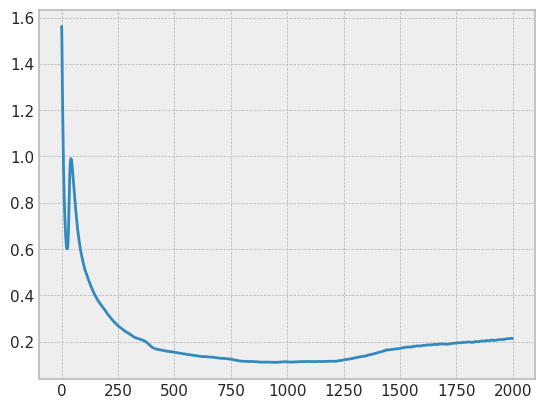

In [68]:

seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_rate = 0.9
# Convert to 2D PyTorch tensors
X_train = torch.tensor(df_drifts[0:int(simulation_count*train_rate)][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(df_drifts[0:int(simulation_count*train_rate)]['f1'].values, dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(df_drifts[int(simulation_count*train_rate):simulation_count][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(df_drifts[int(simulation_count*train_rate):simulation_count]['f1'].values, dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
perform_model = nn.Sequential(
    nn.Linear(5, 50),
    nn.BatchNorm1d(num_features=50),
    nn.ReLU(),
    nn.Linear(50, 20),
    nn.BatchNorm1d(num_features=20),
    nn.ReLU(),
    nn.Linear(20, 1)    
).to(device)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(perform_model.parameters(), lr=0.0001)
 
n_epochs = 2000   # number of epochs to run
batch_size = 500  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    perform_model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = perform_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    perform_model.eval()
    y_pred = perform_model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(perform_model.state_dict())
 
# restore model and return best accuracy
perform_model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [69]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score

predicted_y = perform_model(X_test)
r2 = r2_score(y_test.cpu().data.numpy(),predicted_y.cpu().data.numpy())
print('r2',r2)

r2 -606230.3057237946


## 성능 예측 모델 적용

100%|██████████| 719/719 [00:04<00:00, 161.41it/s]


r2 -236.21844361239468


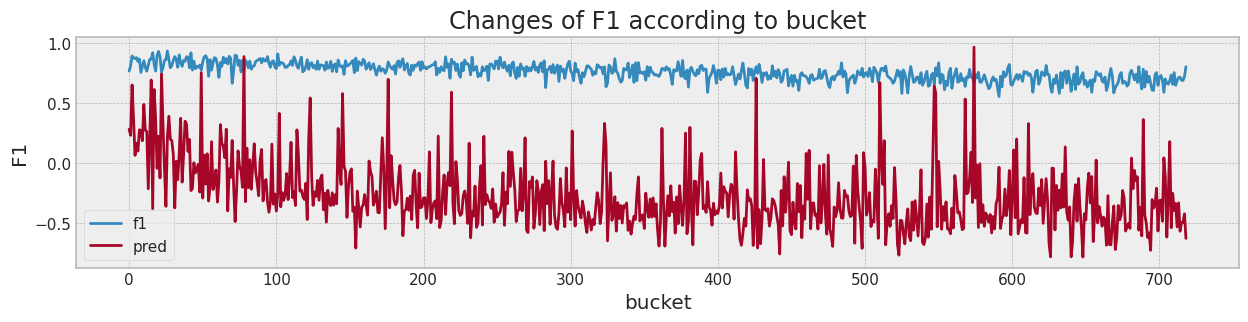

In [70]:

#XT = X[8000:][['x0','x1','x2','x3','z0']]
#yT = X[8000:]['y'].values

bucket_size_array=[100]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = {}
    f1s['f1'] = []
    f1s['pred'] = []
    

    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        #print(tmp_x.shape)
        predicted_y = classifier_model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        ks = __ks_drift(ref_x,X[bk*bucket_size+8000:bk*bucket_size+bucket_size+8000].values)
        
        f1s['f1'].append(f1_)
        tks = torch.tensor(ks[:,0],dtype=torch.float32).reshape(1,5).to(device)
        #print(tks.shape)
        predicted_perform = perform_model(tks)
        #print(predicted_perform.shape)
        
        f1s['pred'].append(predicted_perform.cpu().data.numpy()[0,0])


    r2 = r2_score(f1s['f1'],f1s['pred'])
    print('r2',r2)

    df_f1s = pd.DataFrame(f1s)
    df_f1s.plot(figsize=(15,3))
    plt.ylabel('F1')
    plt.xlabel('bucket')
    plt.title('Changes of F1 according to bucket')
    plt.show()
